In [137]:
import sys
sys.path.insert(1, "../pattern-explorer/src/")

In [138]:
from irf import irf_utils
from irf import irf_jupyter_utils
from irf.ensemble import RandomForestClassifierWithWeights
import pandas as pd
import pattern.preprocessing as prep
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

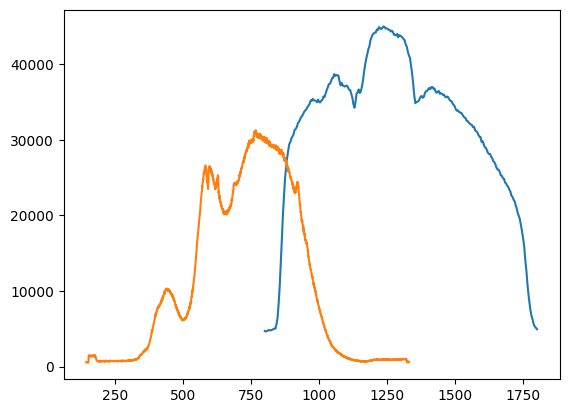

In [139]:
empty_cuvette = pd.read_csv("../data/240109-a549-lps-data/calibration/(empty-cuvvette-l2s)_LBL_2023-10-24_15h53m20s_0x000003f1_0x000003f3.csv", header=5)
plt.plot(np.linspace(800, 1800, 256), empty_cuvette.iloc[:, empty_cuvette.columns == "2000.9"].dropna())
plt.plot(np.linspace(144, 1330, 2048), empty_cuvette.iloc[:, empty_cuvette.columns == "2000.19"].dropna())

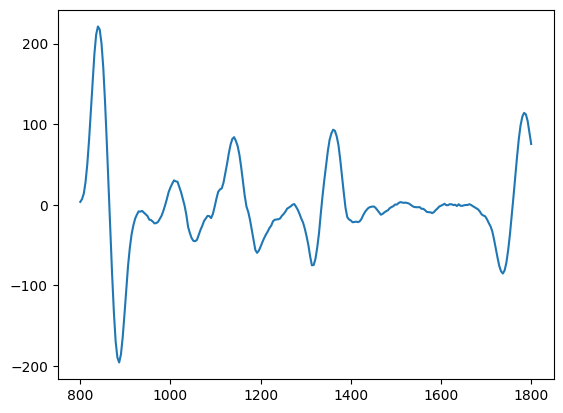

In [140]:
plt.plot(np.linspace(800, 1800, 256), prep._savgol_filter_df(empty_cuvette.iloc[:, empty_cuvette.columns == "2000.9"].dropna(), window_length=21, polyorder=3, deriv=2))

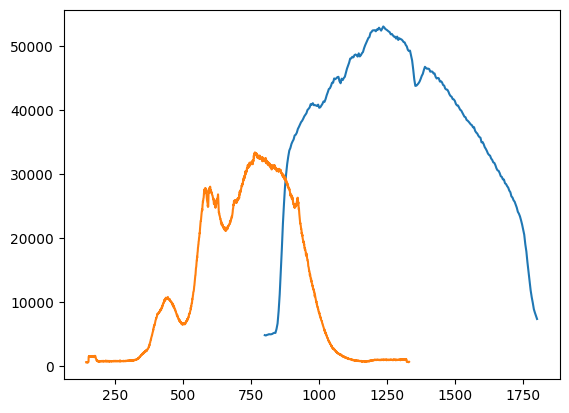

In [141]:
no_cuvette = pd.read_csv("../data/240109-a549-lps-data/calibration/(no-cuvette-light)_LBL_2023-10-24_15h46m35s_0x000003f1_0x000003f3.csv", header=5)
plt.plot(np.linspace(800, 1800, 256), no_cuvette.iloc[:, no_cuvette.columns == "2000.9"].dropna())
plt.plot(np.linspace(144, 1330, 2048), no_cuvette.iloc[:, no_cuvette.columns == "2000.19"].dropna())

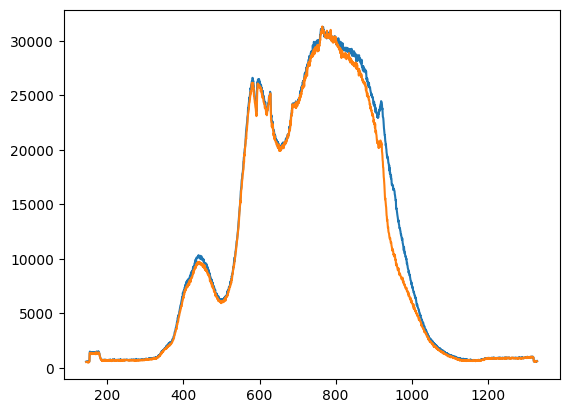

In [142]:
water = pd.read_csv("../data/240109-a549-lps-data/calibration/(water)_LBL_2023-10-24_16h07m25s_0x000003f1_0x000003f3.csv", header=5)
# plt.plot(np.linspace(800, 1800, 256), water.iloc[:, water.columns == "2000.9"].dropna())
plt.plot(np.linspace(144, 1330, 2048), empty_cuvette.iloc[:, empty_cuvette.columns == "2000.19"].dropna())
plt.plot(np.linspace(144, 1330, 2048), water.iloc[:, water.columns == "2100.19"].dropna())

In [143]:
data_folder = Path("../data/240109-a549-lps-data/")
lps_folder = data_folder / "lps"
nolps_folder = data_folder / "no-lps"
lps_folder, nolps_folder

(PosixPath('../data/240109-a549-lps-data/lps'),
 PosixPath('../data/240109-a549-lps-data/no-lps'))

In [144]:
len(list(lps_folder.glob("**/*csv"))), len(list(nolps_folder.glob("**/*csv")))

(203, 191)

In [145]:
lps_data = pd.concat([prep.spectra_pipeline(lps_file, "lps") for lps_file in lps_folder.glob("**/*csv")])
nolps_data = pd.concat([prep.spectra_pipeline(nolps_file, "nolps") for nolps_file in nolps_folder.glob("**/*csv")])
df = pd.concat([lps_data, nolps_data])
df.head()

spec          y hamamatsu                                                    \
wavelength        889.622   893.369   897.116   900.863   904.609   908.356   
0           lps  0.002995  0.005842  0.011147  0.024201  0.044262  0.071192   
0           lps  0.003032  0.005854  0.011182  0.024280  0.044384  0.071302   
0           lps  0.002981  0.005823  0.011141  0.024067  0.043958  0.070684   
0           lps  0.002990  0.005812  0.011081  0.023984  0.043810  0.070424   
0           lps  0.003016  0.005779  0.011064  0.023917  0.043757  0.070295   

spec                                      ...   avaspec                      \
wavelength   912.103    915.85   919.597  ...   1331.29   1331.84   1332.38   
0           0.101513  0.131961  0.155879  ...  0.019804  0.018159  0.014204   
0           0.101606  0.132135  0.156253  ...  0.019656  0.018218  0.014353   
0           0.100860  0.131104  0.154783  ...  0.020054  0.018334  0.014618   
0           0.100350  0.130408  0.153980  ...  0.020018  0.018339  0.014700   
0           0.100057  0.129910  0.153421  ...  0.019768  0.018204  0.014256   

spec                                                                    \
wavelength   1332.92   1333.46   1334.01   1334.55   1335.09   1335.63   
0           0.008327  0.001347  0.000058  0.000047  0.000511  0.000572   
0           0.008527  0.001646  0.000404  0.000503  0.000831  0.000716   
0           0.009172  0.002246  0.000785  0.000511  0.000800  0.000383   
0           0.009267  0.002306  0.000907  0.000870  0.001082  0.000728   
0           0.008103  0.001128  0.000041 -0.000061  0.000258  0.000286   

spec                  
wavelength   1336.18  
0           0.000342  
0           0.000279  
0           0.000071  
0           0.000376  
0           0.000105  

[5 rows x 2305 columns]

In [146]:
y = df.iloc[:,0]
X = df.iloc[:,1:]

In [147]:
pca = PCA(n_components=5)
pca.fit(X)
pca.explained_variance_ratio_

array([0.59161782, 0.06016845, 0.04711479, 0.0242744 , 0.02077328])

In [148]:
pca_transformed = pca.transform(X)
y_color = [1 if cond == "nolps" else 0 for cond in y]

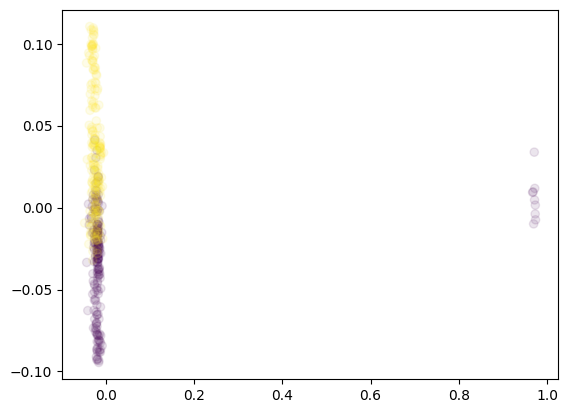

In [149]:
plt.scatter(pca_transformed[:,0], pca_transformed[:,1], c=y_color, alpha=0.1)

In [150]:
# Points on the right seem like outliers
np.argwhere(pca_transformed[:,0] > 0.9).flatten()

array([104, 108, 112, 125, 131, 134, 141, 151, 165])

In [151]:
hamamatsu_wls = [w[1] for w in X.loc[:, ("hamamatsu", slice(None))]]
avaspec_wls = [w[1] for w in X.loc[:, ("avaspec", slice(None))]]

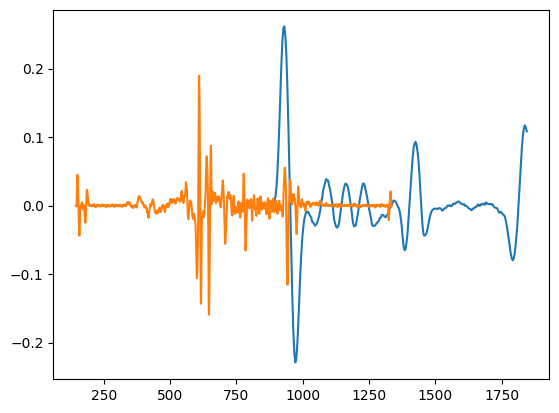

In [152]:
plt.plot(hamamatsu_wls, X.loc[:, ("hamamatsu", slice(None))].iloc[112, :])
plt.plot(avaspec_wls, X.loc[:, ("avaspec", slice(None))].iloc[112, :])

In [153]:
import numpy as np
df["outlierish"] = pca_transformed[:,0] < 0.9
# df.iloc[np.argwhere(pca_transformed[:,0] < 0.9).flatten()]
filtered = df[df["outlierish"]].drop(columns=("outlierish"))
X_filtered = filtered.iloc[:,1:]
y_filtered = filtered.iloc[:,0]

/home/dondon/src/irf-poc/.venv/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [154]:
new_cols = ["target"] + [x[1] for x in filtered.columns[1:]]
renamed = filtered.copy()
renamed.columns = new_cols
print(renamed.head())
renamed["target"] = [1 if t == "lps" else 0 for t in renamed["target"]]
renamed.to_csv("../data/preprocessed.csv", index=False)
filtered.to_csv("../data/filtered-multi.csv", index=False)

  target   889.622   893.369   897.116   900.863   904.609   908.356  \
0    lps  0.002995  0.005842  0.011147  0.024201  0.044262  0.071192   
0    lps  0.003032  0.005854  0.011182  0.024280  0.044384  0.071302   
0    lps  0.002981  0.005823  0.011141  0.024067  0.043958  0.070684   
0    lps  0.002990  0.005812  0.011081  0.023984  0.043810  0.070424   
0    lps  0.003016  0.005779  0.011064  0.023917  0.043757  0.070295   

    912.103    915.85   919.597  ...   1331.29   1331.84   1332.38   1332.92  \
0  0.101513  0.131961  0.155879  ...  0.019804  0.018159  0.014204  0.008327   
0  0.101606  0.132135  0.156253  ...  0.019656  0.018218  0.014353  0.008527   
0  0.100860  0.131104  0.154783  ...  0.020054  0.018334  0.014618  0.009172   
0  0.100350  0.130408  0.153980  ...  0.020018  0.018339  0.014700  0.009267   
0  0.100057  0.129910  0.153421  ...  0.019768  0.018204  0.014256  0.008103   

    1333.46   1334.01   1334.55   1335.09   1335.63   1336.18  
0  0.001347  0.000058 

[0.14984623 0.11686075 0.05990562 0.05127914 0.04361892]


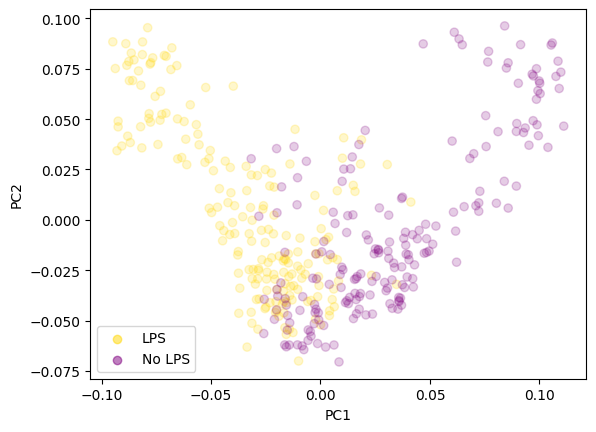

In [180]:
pca = PCA(n_components=5)
pca.fit(X_filtered)
print(pca.explained_variance_ratio_)
pca_transformed = pca.transform(X_filtered)
y_color = ["purple" if cond == "nolps" else "gold" for cond in y_filtered]
plt.scatter(pca_transformed[:,0], pca_transformed[:,1], c=y_color, alpha=0.2)
plt.scatter([],[], color="gold", label="LPS", alpha=0.5)
plt.scatter([],[], color="purple", label="No LPS", alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()

## iRF

In [156]:
from sklearn.preprocessing import label_binarize

y_labels = label_binarize(y_filtered, classes=["lps", "nolps"])
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_labels, random_state=0)
(
    all_rf_weights,
    all_K_iter_rf_data,
    all_rf_bootstrap_output,
    all_rit_bootstrap_output,
    stability_score,
) = irf_utils.run_iRF(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    K=5,  # number of iteration
    rf=RandomForestClassifierWithWeights(n_estimators=20),
    B=30,
    random_state_classifier=2018,  # random seed
    propn_n_samples=0.2,
    bin_class_type=1,
    M=20,
    max_depth=5,
    noisy_split=False,
    num_splits=2,
    n_estimators_bootstrap=5,
)

/home/dondon/src/irf-poc/.venv/lib/python3.8/site-packages/irf/ensemble/wrf.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return super(RandomForestClassifierWithWeights, self).fit(X, y, sample_weight)
/home/dondon/src/irf-poc/.venv/lib/python3.8/site-packages/irf/ensemble/wrf.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return super(RandomForestClassifierWithWeights, self).fit(X, y, sample_weight)
/home/dondon/src/irf-poc/.venv/lib/python3.8/site-packages/irf/ensemble/wrf.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return super(RandomForestClassifierWithWeights, self).fit(X, y, sample_weight)
/home/dondon/src/irf-poc/.venv/lib/python3.

In [157]:
all_rf_bootstrap_output["rf_bootstrap0"]["rf_validation_metrics"].keys()

dict_keys(['hamming_loss', 'log_loss', 'recall_score', 'precision_score', 'accuracy_score', 'f1_score', 'confusion_matrix', 'zero_one_loss'])

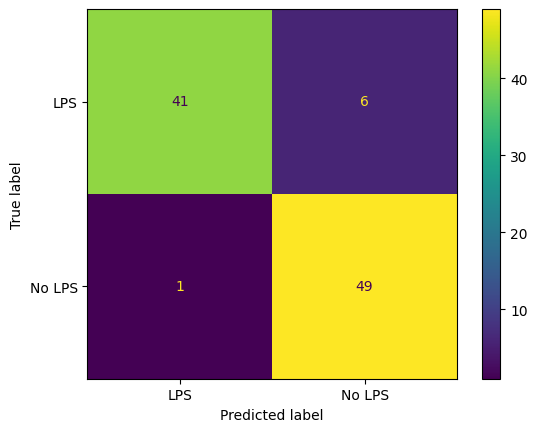

In [158]:
import sklearn.metrics as smetrics

smetrics.ConfusionMatrixDisplay(all_rf_bootstrap_output["rf_bootstrap4"]["rf_validation_metrics"]["confusion_matrix"], ["LPS", "No LPS"]).plot()

In [159]:
all_rf_bootstrap_output.keys()

dict_keys(['rf_bootstrap0', 'rf_bootstrap1', 'rf_bootstrap2', 'rf_bootstrap3', 'rf_bootstrap4', 'rf_bootstrap5', 'rf_bootstrap6', 'rf_bootstrap7', 'rf_bootstrap8', 'rf_bootstrap9', 'rf_bootstrap10', 'rf_bootstrap11', 'rf_bootstrap12', 'rf_bootstrap13', 'rf_bootstrap14', 'rf_bootstrap15', 'rf_bootstrap16', 'rf_bootstrap17', 'rf_bootstrap18', 'rf_bootstrap19', 'rf_bootstrap20', 'rf_bootstrap21', 'rf_bootstrap22', 'rf_bootstrap23', 'rf_bootstrap24', 'rf_bootstrap25', 'rf_bootstrap26', 'rf_bootstrap27', 'rf_bootstrap28', 'rf_bootstrap29'])

In [160]:
sorted(list(stability_score.items()), key=lambda x: x[1])[-20:]

[('319_1561', 0.03333333333333333),
 ('307_1355_1561', 0.03333333333333333),
 ('1355', 0.03333333333333333),
 ('1562_1603', 0.03333333333333333),
 ('307_320', 0.03333333333333333),
 ('49_319', 0.06666666666666667),
 ('319_827', 0.06666666666666667),
 ('321_1561', 0.06666666666666667),
 ('320_1355', 0.06666666666666667),
 ('322', 0.1),
 ('310', 0.1),
 ('4_319', 0.1),
 ('312', 0.13333333333333333),
 ('311', 0.13333333333333333),
 ('319_321', 0.13333333333333333),
 ('319_320', 0.13333333333333333),
 ('308', 0.16666666666666666),
 ('319', 0.4),
 ('321', 0.5333333333333333),
 ('320', 0.7)]

In [161]:
filtered.columns[1561]

('avaspec', 920.868)

In [162]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
rf_clf = RandomForestClassifier(n_estimators=100, random_state=717)
y_pred = cross_val_predict(rf_clf, X_filtered, y_filtered, cv=10)

In [163]:
import sklearn.metrics as skmetrics
skmetrics.classification_report(y_filtered, y_pred, output_dict=True)

{'lps': {'precision': 0.9435897435897436,
  'recall': 0.9484536082474226,
  'f1-score': 0.9460154241645243,
  'support': 194},
 'nolps': {'precision': 0.9473684210526315,
  'recall': 0.9424083769633508,
  'f1-score': 0.9448818897637795,
  'support': 191},
 'accuracy': 0.9454545454545454,
 'macro avg': {'precision': 0.9454790823211876,
  'recall': 0.9454309926053868,
  'f1-score': 0.9454486569641519,
  'support': 385},
 'weighted avg': {'precision': 0.9454643602012023,
  'recall': 0.9454545454545454,
  'f1-score': 0.9454530733319471,
  'support': 385}}

In [179]:
sum([1 if (x=="lps") and (y =="lps") else 0 for x, y in zip(y_filtered, y_pred)])

184

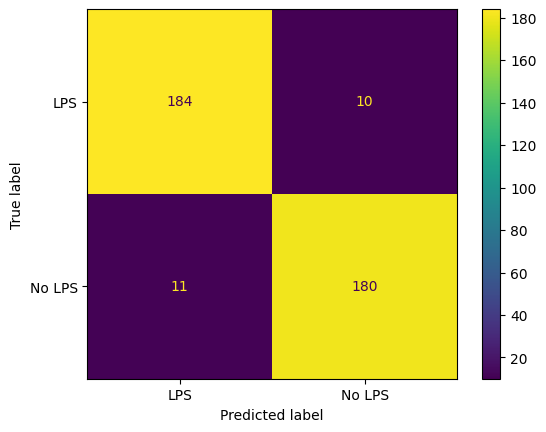

In [177]:
skmetrics.ConfusionMatrixDisplay(skmetrics.confusion_matrix(y_filtered, y_pred), display_labels=["LPS", "No LPS"]).plot(values_format="")